In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.stats import spearmanr, pearsonr
import statsmodels.api as sm
import pickle
import warnings
warnings.filterwarnings('ignore')
import re
from scipy.interpolate import UnivariateSpline


In [2]:
from countryinfo import CountryInfo
from country_list import countries_for_language

In [3]:
#Download datset (HCED Data v2.csv) from https://journals.sagepub.com/doi/10.1177/00220027221119085

In [4]:
emnlp = False #Set to True if you want to see the result using the Xie et al., 2019 framework


In [5]:
if emnlp:
    files = pickle.load(open('./data/emnlp_scores_coha.p','rb'))
    files.keys()
    df1 = files['moral_relevance']
    df1['property'] = ['previous_link'] * len(df1)
    
    df2 = files['moral_polarity']
    df2['property'] = ['polarity'] * len(df2)
    
    ts_df = pd.concat((df1,df2),ignore_index = True)
    ts_df['words'] = ts_df['word']
    ts_df.drop(['word','vector'],axis = 1,inplace = True)
    ts_df['outputs_z'] = ts_df['outputs'].apply(lambda p : np.log(p / (1 - p)))
    ts_df = ts_df.loc[ts_df.year >= 1850].reset_index(drop = True)
                                                
else:
    ts_df = pd.read_csv('./data/SWOW_prediction/eval/time_series/ts_df.csv')
    
    ts_df = ts_df.groupby(['words','year','property'])[['outputs_z','count']].mean().reset_index()
    ts_df = ts_df.loc[ts_df['count'] >= 50]

In [6]:
df = pd.read_csv('./data/HCED Data v2.csv',encoding='latin-1')
df.sample(5)

,Unnamed: 0,ID,Country,Latitude,Longitude,Page,Battle,Year,Participants,War,...,Loser,Participant 1,Participant 2,Lehmann Zhukov Scale,Theatre,Polygon,Massacre,Alternative Sources Consulted,Infered Scale,Minor
13057,12302.0,Queenston1812,Canada,43.161896,-79.05264,832,Queenston,1812,"['American', 'Lake Ontario', 'Brock', 'America...",War of 1812,...,United States,NaN,NaN,2.0,Land,NaN,No,"Encyclopedia of Warfare, Showalter, 2014, p569...",NaN,NaN
3043,2918.0,Cannae1018,Italy,41.284605,16.1491646,194,Cannae,1018,['Italy'],Norman Conquest of Sicily,...,"Normans, Lombards",NaN,NaN,NaN,Land,NaN,No,NaN,NaN,NaN
2922,2801.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13837,13034.0,St Marys1645-1646,United States,38.185995,-76.4369652,882,St Marys,1645-1646,"['England', 'Puritan Virginia', 'Puritan', 'Ma...",Ingles Rebellion,...,Virginia,NaN,NaN,NaN,Land,NaN,No,NaN,NaN,NaN
453,442.0,Alexandria1167,Egypt,31.200092,29.9187387,29,Alexandria,1167,"['Egypt', 'Cairo', 'Jerusalem']",Crusader Invasion of Egypt,...,Egypt,NaN,NaN,NaN,Land,NaN,No,NaN,NaN,NaN


In [7]:
df['Country'].unique()

array([nan, 'Germany', 'Netherlands', 'Latvia', 'Sweden', 'Iran',
       'Nigeria', 'Ghana', 'Peru', 'Chad', 'United Kingdom', 'Kenya',
       'Benin', 'Egypt', 'Bulgaria', 'Sudan', 'Israel', 'Mexico', 'Italy',
       'United States', 'Paraguay', 'Greece', 'Hungary', 'Turkey',
       'India', 'Tunisia', 'Ethiopia', 'Yemen', 'France', 'Myanmar',
       'Papua New Guinea', 'Romania', 'Belgium', 'Eritrea', 'Azerbaijan',
       'Afghanistan', 'Pakistan', 'Spain', 'China', 'Syria', 'Iraq',
       'Libya', 'Switzerland', 'Japan', 'Georgia', 'Uzbekistan', 'Russia',
       'Saudi Arabia', 'Finland', 'Albania', 'Portugal', 'Morocco',
       'Cuba', 'Serbia', 'Algeria', 'South Africa', 'Ukraine',
       'Guatemala', 'Denmark', 'Norway', 'Chile', 'Indonesia', 'Angola',
       'Western Sahara', 'Jordan', 'Austria', 'Ecuador', 'Madagascar',
       'Mali', 'Palau', 'Cambodia', 'South Korea', 'Venezuela', 'Lebanon',
       'Vietnam', 'Canada', 'El Salvador', 'Argentina', 'Colombia',
       'Ireland',

In [8]:
df = df.loc[~pd.isna(df.Year)].reset_index(drop = True)

In [9]:

us_df = df.copy(deep = True)

In [10]:
decades = []
for i, row in us_df.iterrows():
    year = row['Year']
    if '-' not in year:
        
        decades.append((int(year) // 10) * 10)
        
    else:
        years = year.split()
        if len(years) == 2:
            year1, year2 = year2
            year1 = int(year1)
            d1 = int(year1 // 10) * 10
            year2 = int(year2)
            d2 = int(year2 // 10) * 10
            decades.append(max(d1, d2))
            
        else:
            decades.append(None)
    

In [11]:
us_df['Decade'] = decades
us_df = us_df.loc[us_df.Decade >= 1850].reset_index(drop = True)

In [12]:
from nltk import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
from ast import literal_eval

In [13]:
us_df =us_df.loc[~pd.isna(us_df.Participants)].reset_index(drop = True)
len(us_df)

2973

In [14]:
total_df = pd.DataFrame()
for i, row in us_df.iterrows():
     
    if row['Participants'][0] != '[':
        continue
    participants = literal_eval(row['Participants'])
    
    participants = [lemmatizer.lemmatize(x.lower().strip()) for x in participants]
    scale = float(row['Lehmann Zhukov Scale'])
    
    
    small_ts_df = ts_df.loc[(ts_df.year == row['Decade']) & (ts_df.words.isin(participants))]
    
    if row['War'][0] == '[':
        war = literal_eval(row['War'])
    else:
        war = row['War']
    if isinstance(war, list):
        war = war[0]
    
    small_ts_df['War'] = war
    small_ts_df['Scale'] = scale
    total_df = pd.concat((total_df, small_ts_df), ignore_index = True)

In [15]:
main_df = total_df.copy(deep = True)
total_df = total_df.loc[total_df.Scale >= 3]

In [16]:
war_df = main_df.groupby(['War','year','property'])[['outputs_z','Scale']].mean().reset_index()
war_df.sort_values(by = 'Scale',ascending = False)

,War,year,property,outputs_z,Scale
766,Russo-Finnish War,1940,polarity,0.334773,6.000000
767,Russo-Finnish War,1940,previous_link,-0.406999,6.000000
960,World War II,1940,polarity,0.440252,5.000000
961,World War II,1940,previous_link,1.121892,5.000000
121,3rd Chinese Revolutionary Civil War,1940,previous_link,0.876946,4.571429
...,...,...,...,...,...
941,Western Saharan Wars,1950,previous_link,-0.059521,NaN
948,World War I,1940,polarity,-0.127148,NaN
949,World War I,1940,previous_link,0.764896,NaN
972,Zulu Civil Wars,1880,polarity,-0.131875,NaN


In [17]:
war_scale = main_df.groupby(['War','year']).Scale.max().to_dict()
war_df['Scale'] = [war_scale[(w, y)] for w, y in zip(war_df.War, war_df.year)]

In [18]:
all_words = total_df.words.unique()
len(all_words)

200

In [19]:
small_ts_df = ts_df.loc[ts_df.words.isin(all_words)]

In [20]:
compare_list_rows = []
for i, row in total_df.iterrows():
    word = row['words']
    year = row['year']
    p = row['property']
    score = row['outputs_z']
    word_ts_df = small_ts_df.loc[(small_ts_df.words == word) & (small_ts_df.property == p)]
    if p == 'polarity': #Most negative year
        top = word_ts_df.sort_values(by = 'outputs_z').head(1)
    else: #Most positive year
        top = word_ts_df.sort_values(by = 'outputs_z',ascending = False).head(1)
    compare_list_rows.append({
        'word':word,
        'war_year':year,
        'max_year': top.year.iloc[0],
        'war_moral_score': score,
        'max_moral_score':top.outputs_z.iloc[0],
        'property':p
    })

In [21]:
compare_df = pd.DataFrame(compare_list_rows).drop_duplicates()
compare_df['year_diff'] = compare_df['max_year'] - compare_df['war_year']
compare_df['score_diff'] = compare_df['max_moral_score'] - compare_df['war_moral_score']
rel_df = compare_df.loc[compare_df.property == 'previous_link']
pol_df = compare_df.loc[compare_df.property == 'polarity']

In [22]:
rel_df = rel_df.sort_values(by = 'war_moral_score',ascending = False).groupby('word').head(1).reset_index(drop = True)
pol_df = pol_df.sort_values(by = 'war_moral_score',ascending = True).groupby('word').head(1).reset_index(drop = True)

In [23]:
rel_df.loc[rel_df.word == 'axis']

,word,war_year,max_year,war_moral_score,max_moral_score,property,year_diff,score_diff
4,axis,1940,1940,2.509453,2.509453,previous_link,0,0.0


In [24]:
small_total_df = total_df.copy(deep = True)

In [25]:
compare_list_rows = []
for w in all_words:
    for p in ['previous_link','polarity']:
        war_years = total_df.loc[(total_df.words == w) & (total_df.property == 'polarity')].\
        groupby(['year'])['War'].apply(list).to_dict()
        w_war_df = small_total_df.loc[(small_total_df.words == w) & (small_total_df.year.isin(war_years)) & \
                                                                     (small_total_df.property == p)]
        # years = w_war_df.year.unique()
        years = list(war_years.keys())
        n_w_war_df =  small_ts_df.loc[(small_ts_df.words == w) & ~(small_ts_df.year.isin(years)) & (small_ts_df.property == p)]
        
        war_score = w_war_df.outputs_z.mean()
        n_war_score = n_w_war_df.outputs_z.mean()
        compare_list_rows.append({
            'word':w,
            'property':p,
            'war_years': len(years),
            'n_war_years': len(n_w_war_df.year.unique()),
           
            'war_score': war_score,
            'n_war_score':n_war_score
        })

In [26]:
compare_df = pd.DataFrame(compare_list_rows).dropna()
compare_df['diff'] = compare_df['war_score'] - compare_df['n_war_score']
compare_df['year_diff'] = compare_df['war_years'] - compare_df['n_war_years']
rel_compare_df = compare_df.loc[compare_df.property == 'previous_link']
pol_compare_df = compare_df.loc[compare_df.property == 'polarity']


In [27]:
plot_df =  rel_compare_df.copy()
plot_df['rel_diff'] = list(plot_df['diff'])
plot_df['pol_diff'] = list(pol_compare_df['diff'])
plot_df = plot_df[['rel_diff','pol_diff']]
plot_df = plot_df.melt()

In [28]:
all_df = pd.read_csv('./data/SWOW_prediction/eval/time_series/ts_df.csv')
all_df = all_df.loc[all_df['count'] >= 50]
all_df = all_df.groupby(['train_section','year','property']).outputs_z.mean().reset_index()

In [29]:
from adjustText import adjust_text


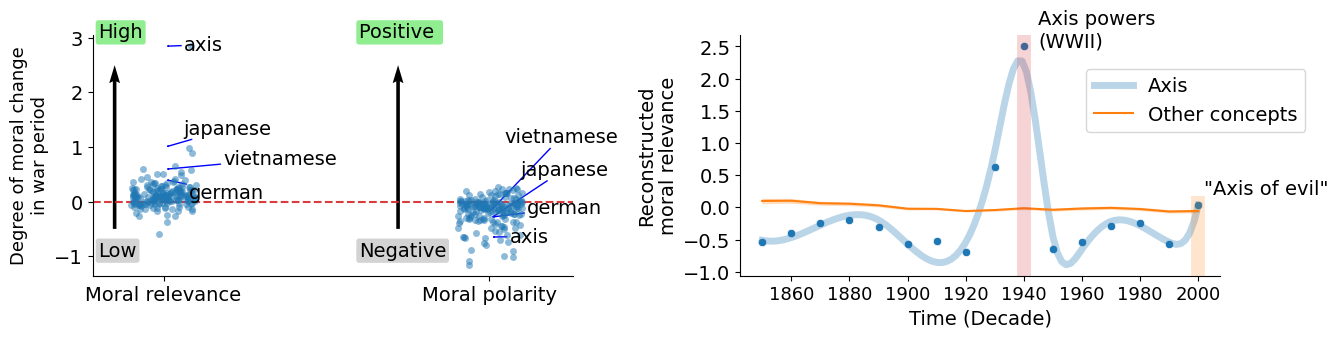

In [30]:
plotting_words = ['axis','japanese', 'german','vietnamese']
annotations = []
fig, axes = plt.subplots(1, 2, figsize = (12, 3),sharey = False)
fig.tight_layout()
plt.subplots_adjust( wspace=0.35)
ax = axes[0]
sns.stripplot(data = plot_df, x= 'variable' , y = 'value',color = 'tab:blue',alpha = 0.5,ax =ax)
ax.axhline(y = 0,color = 'tab:red',alpha = 0.9,ls = '--')
ax.set_ylabel('Degree of moral change\nin war period',fontsize =13 )
ax.set_xticklabels(['Moral relevance','Moral polarity'],fontsize =14 )
ax.set_xlabel('')
# ax.text(s = 'c)', x = -0.85, y = 3.5,fontsize =18)
ax.set_xticklabels(ax.get_xticklabels(),fontsize = 14)
ax.set_yticklabels(ax.get_yticklabels(),fontsize = 14)

for w in plotting_words:

    w_rel = rel_compare_df.loc[rel_compare_df.word == w].iloc[0]
    w_pol = pol_compare_df.loc[pol_compare_df.word == w].iloc[0]
    annotations.append(ax.annotate(w, (0, w_rel['diff']),
                    color = 'black',size = 14))
    annotations.append(ax.annotate(w, (1, w_pol['diff']),
                    color = 'black',size = 14))


adjust_text(annotations,expand=(1.5, 1.5),arrowprops=dict(arrowstyle='->', color='blue'),ax = ax)

ax.quiver(-0.15, -0.5, 0, 3, angles='xy', scale_units='xy', scale=1)

    
ax.text(x = -0.2, y = -1, s = 'Low', color = 'Black',fontsize = 14,
        bbox=dict(facecolor='lightgrey', edgecolor='lightgrey', boxstyle='round,pad=0.1'))


    
ax.text(x = -0.2, y = 3, s = 'High', color = 'Black',fontsize = 14,
        bbox=dict(facecolor='lightgreen', edgecolor='lightgreen', boxstyle='round,pad=0.1'))



ax.text(x = 0.6, y = -1, s = 'Negative', color = 'Black',fontsize = 14,
        bbox=dict(facecolor='lightgrey', edgecolor='lightgrey', boxstyle='round,pad=0.1'))



ax.text(x = 0.6, y = 3, s = 'Positive ', color = 'Black',fontsize = 14,
        bbox=dict(facecolor='lightgreen', edgecolor='lightgreen', boxstyle='round,pad=0.1'))

ax.quiver(0.72, -0.5, 0, 3, angles='xy', scale_units='xy', scale=1)

    
          
ax = axes[1]
entity ='axis'
k = 3
war_years = total_df.loc[(total_df.words == entity) & (total_df.property == 'polarity')].\
    groupby(['year'])['War'].apply(set).to_dict()


sns.scatterplot(data = small_ts_df.loc[small_ts_df.words == entity].loc[small_ts_df.property == 'previous_link'],
        x = 'year',
        y = 'outputs_z',
        ax = ax)

x = small_ts_df.loc[small_ts_df.words == entity].loc[small_ts_df.property == 'previous_link'].year
y = small_ts_df.loc[small_ts_df.words == entity].loc[small_ts_df.property == 'previous_link'].outputs_z
spl = UnivariateSpline(x, y,k=k, s = 0.35)
xs  = np.linspace(x.min(), x.max(), 100)

ax.plot(xs, spl(xs), 'tab:blue', lw=5,alpha=0.3,label = entity[0].upper() + entity[1:])
ax.text(x = 1945, y = 2.5, s = 'Axis powers\n(WWII)',fontsize = 14)
ax.text(x = 2002, y = 0.2, s = '"Axis of evil"',fontsize = 14)
min_year = small_ts_df.loc[small_ts_df.words == entity].loc[small_ts_df.property == 'previous_link'].year.min()
sns.lineplot(data = all_df.loc[all_df.property == 'previous_link'].loc[all_df.year >= min_year],
             x = 'year',
             y = 'outputs_z', label = 'Other concepts',ax = ax,color = 'tab:orange')

ax.legend(fontsize = 14,bbox_to_anchor = (0.7, 0.9))
ax.set_xticklabels(ax.get_xticklabels(),fontsize = 13)
ax.set_yticklabels(ax.get_yticklabels(),fontsize = 14)
ax.set_xlabel('Time (Decade)',fontsize =14 )
ax.set_ylabel('Reconstructed\nmoral relevance',fontsize =14 )
for year, war in war_years.items():
    ax.axvline(x = year,color = 'tab:red',linewidth = 10,alpha = 0.2,label = ", ".join(war))
ax.axvline(x = 2000,ymax = 0.3,color = 'tab:orange',linewidth = 10,alpha = 0.2,label = ", ".join(war))
sns.despine()

plt.savefig('notebooks/figs/coha_war_display3.png',dpi = 400, bbox_inches = 'tight')
plt.savefig('notebooks/figs/coha_war_display3.pdf',dpi = 400, bbox_inches = 'tight')

In [31]:
def statistic(x, y, axis):
    return np.mean(x, axis=axis) - np.mean(y, axis=axis)
import scipy.stats as st

In [32]:
st.permutation_test([rel_compare_df.war_score.to_numpy(), rel_compare_df.n_war_score.to_numpy()],
                    statistic = statistic,
                    permutation_type='samples', alternative = 'greater')

PermutationTestResult(statistic=0.13019690459688782, pvalue=0.0001, null_distribution=array([-0.00696397, -0.01786743, -0.03064571, ..., -0.03098315,
       -0.02542277,  0.01100386]))

In [33]:
st.permutation_test([pol_compare_df.war_score.to_numpy(), pol_compare_df.n_war_score.to_numpy()],
                    statistic = statistic,
                    permutation_type='samples', alternative = 'less')

PermutationTestResult(statistic=-0.17058752350907874, pvalue=0.0001, null_distribution=array([-0.00518881,  0.0208086 , -0.03547183, ...,  0.00112438,
        0.02523332,  0.03424353]))

In [34]:
import pingouin

In [35]:
pingouin.ttest(rel_compare_df.war_score, rel_compare_df.n_war_score,paired = True,
              alternative = 'greater', r = 0.7)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,6.234583,182,greater,1.538716e-09,"[0.1, inf]",0.153328,5.788e+06,0.663345


In [36]:
pingouin.ttest(pol_compare_df.war_score, pol_compare_df.n_war_score,paired = True,
              alternative = 'less', r = 0.7)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-8.653282,182,less,1.298826e-15,"[-inf, -0.14]",0.166957,4.557e+12,0.727507


In [37]:
small_ts_df = ts_df.loc[ts_df.words.isin(all_words)]

In [38]:
from scipy.stats import binomtest


In [39]:
result = binomtest(len(rel_compare_df.loc[rel_compare_df['diff'] > 0]), 
          n=len(rel_compare_df), p=0.5, alternative='greater')
print(result)
print(result.proportion_ci(confidence_level=0.95))

BinomTestResult(k=139, n=183, alternative='greater', statistic=0.7595628415300546, pvalue=5.602415483550569e-13)
ConfidenceInterval(low=0.7018997331593646, high=1.0)


In [40]:
result = binomtest(len(pol_compare_df.loc[pol_compare_df['diff'] < 0]), 
          n=len(pol_compare_df), p=0.5, alternative='greater')
print(result)
print(result.proportion_ci(confidence_level=0.95))


BinomTestResult(k=142, n=183, alternative='greater', statistic=0.7759562841530054, pvalue=1.528528302969576e-14)
ConfidenceInterval(low=0.7193347616362886, high=1.0)


In [41]:
from operator import concat
from functools import reduce

In [42]:
countries = list(us_df.Winner.unique()) + list(us_df.Loser.unique())
countries = set(countries)
countries = [x.split(',') for x in countries if not pd.isna(x)]
countries = set(reduce(concat, countries))
countries = [x.lower().strip() for x in countries]

In [43]:
country_mapping = {'argentine federalists': 'argentina',
                   'ikhwan brotherhood': 'ikhwan',
                   'chinese nationalists': 'china',
                   'united kingdom': 'britain',
                   'cambodian rebels':'cambodia',
                   'warlord sun zuanfang': 'zuanfang',
                   'north korea':'korea',
                   'chinese communists':'china',
                   'indonesian rebels': 'indonesia',
                   'argentinian rebels': 'argentina',
                   'republic of korea':'korea',
                   'ottoman empire': 'ottoman',
                   'garibaldi\'s rebels': 'garibaldi',
                   'argentinian government': 'argentina',
                   'spanish republicans': 'spain',
                   'senussi rebels':'senussi',
                   'habsburg empire':'habsburg',
                   'czechoslovak legion':'czechoslovakia',
                   'polish rebels':'poland',
                   'sudanese islamists':'sudan',
                   'north vietnam':'vietnam',
                   'south korea':'korea',
                   'united states':'america',
                   'united states of america':'america',
                   'mexican conservatives':'mexico',
                   'tekkes tribesmen': 'tekkes',
                   'white russians':'russia',
                   'spanish nationalists':'spain',
                   'mexican liberals':'mexico',
                   'qing china':'china',
                   'south vietnam':'vietnam',
                    'chinese boxer rebels':'china',
                    'arab rebels':'arab',
                   'sudanese mahdists':'sudan',
                    'indian rebels':'indian',
                   
                     'greek communists':'greece',
                    'south vietnam':'vietnam',
                
                     'confederate states of america':'confederate',

                     'untied kingdom':'britain',
                     'soviet union':'russia',
                   
                     'united states':'america',
                     
                     'buenos aries':'argentina'}

In [44]:

total_df = pd.DataFrame()
list_rows = []
for i, row in us_df.iterrows():
    if pd.isna(row['Lehmann Zhukov Scale']) or row['Lehmann Zhukov Scale'] < 3:
        continue
     
    winner = row['Winner']
    loser = row['Loser']
    if pd.isna(winner) or pd.isna(loser):
        continue
        
    winner = winner.split(',')
    winner = [x.lower().strip() for x in winner]
    winner = [country_mapping[x] if x in country_mapping else x for x in winner]
    
    loser = loser.split(',')
    loser = [x.lower().strip() for x in loser]
    loser = [country_mapping[x] if x in country_mapping else x for x in loser]
    if " ".join(winner) == " ".join(loser):
        continue
    scale = float(row['Lehmann Zhukov Scale'])
    
    
    small_ts_df = ts_df.loc[(ts_df.year == row['Decade']) & (ts_df.words.isin(winner))]
    if len(small_ts_df) == 0:
        continue
    if row['War'][0] == '[':
        war = literal_eval(row['War'])
    else:
        war = row['War']
    if isinstance(war, list):
        war = war[0]
    
    small_ts_df['War'] = war
    small_ts_df['Scale'] = scale
    small_ts_df['Winner'] = [True] * len(small_ts_df)
    
    winner_scores = small_ts_df.groupby('property').outputs_z.mean().to_dict()
    
    total_df = pd.concat((total_df, small_ts_df), ignore_index = True)

    small_ts_df = ts_df.loc[(ts_df.year == row['Decade']) & (ts_df.words.isin(loser))]
    if len(small_ts_df) == 0:
        continue
    if row['War'][0] == '[':
        war = literal_eval(row['War'])
    else:
        war = row['War']
    if isinstance(war, list):
        war = war[0]
    
    small_ts_df['War'] = war
    small_ts_df['Scale'] = scale
    small_ts_df['Winner'] = [False] * len(small_ts_df)
    loser_scores = small_ts_df.groupby('property').outputs_z.mean().to_dict()
    
    total_df = pd.concat((total_df, small_ts_df), ignore_index = True)
    list_rows.append({
        'War':war,
        'Scale':scale,
        'Winner': ", ".join(winner),
        'Loser': ", ".join(loser),
        'Decade': row['Decade'],
        'loser_relevance': loser_scores['previous_link'],
        'loser_polarity': loser_scores['polarity'],
        'winner_relevance': winner_scores['previous_link'],
        'winner_polarity': winner_scores['polarity'],
    })
    
    
        

In [45]:
compare_df = pd.DataFrame(list_rows)
compare_df = compare_df[['Winner','Loser','Decade',
                         'loser_relevance',	'loser_polarity',	
                         'winner_relevance',	'winner_polarity']].drop_duplicates()

In [46]:
compare_df

,Winner,Loser,Decade,loser_relevance,loser_polarity,winner_relevance,winner_polarity
0,america,germany,1940.0,1.665519,0.028398,-0.067367,0.710717
1,germany,russia,1910.0,-0.369616,0.161036,1.504815,0.394330
2,iran,iraq,1980.0,0.567560,-2.023405,0.399438,-0.058305
3,israel,egypt,1960.0,-0.483810,-0.120511,0.522086,-0.322204
4,italy,ethiopia,1930.0,0.035685,-1.730640,0.373930,-0.161130
...,...,...,...,...,...,...,...
513,germany,poland,1940.0,0.331420,-0.308799,1.665519,0.028398
514,japan,china,1890.0,0.703019,-0.237774,-0.375236,-0.270505
515,"britain, america, canada, france",germany,1940.0,1.665519,0.028398,-0.085836,0.282715
521,south africa,germany,1910.0,1.504815,0.394330,0.336991,-0.362898


In [47]:
pingouin.ttest(compare_df.winner_relevance, compare_df.loser_relevance,paired = True,
               alternative = 'less',
              r = 0.7)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-1.82776,209,less,0.034506,"[-inf, -0.01]",0.197293,0.799,0.885884


In [48]:
pingouin.ttest(compare_df.winner_polarity, compare_df.loser_polarity,paired = True,
              alternative = 'greater', r = 0.7)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,2.844185,209,greater,0.002447,"[0.09, inf]",0.271667,7.811,0.988672
